In [2]:
import os 
print(os.getcwd())

try:
    os.chdir("../../workshop-3")

except FileNotFoundError:
    print("""
        FileNotFoundError - The directory may not exist or you might not be in the specified path.
        If this has already worked, do not run this block again, as the current directory is already set to workshop-003.
        """)
    
print(os.getcwd())

c:\semestres_uao\ETL\ETL_workshops\workshop_003\workshop-3\notebooks
c:\semestres_uao\ETL\ETL_workshops\workshop_003\workshop-3


In [11]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
import xgboost as xgb
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [4]:
df = pd.read_csv("./data/transform_data/transform_happiness_score.csv")

df.head()

,country,region,happiness_score,economy,family,health,freedom,government_corruption,generosity,year
0,Switzerland,Western Europe,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2015
1,Iceland,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2015
2,Denmark,Western Europe,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2015
3,Norway,Western Europe,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2015
4,Canada,North America,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2015


In [13]:
# 2. Definir X e y
X = df.drop(['happiness_score', 'country'], axis=1)
y = df['happiness_score']

# 3. Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# 4. Split fijo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Preprocesamiento para columnas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ],
    remainder='passthrough'
)

# 6. Definir modelos con pipelines
models = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
    ])
}

# 7. Entrenar y evaluar
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'model': name,
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'explained_variance': explained_variance_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values('r2_score', ascending=False)
print(results_df)

              model  r2_score       mae       mse      rmse  \
4           XGBoost  0.830954  0.347756  0.205624  0.453458   
2      RandomForest  0.830589  0.344008  0.206068  0.453947   
3  GradientBoosting  0.819630  0.351709  0.219399  0.468400   
0  LinearRegression  0.754294  0.415372  0.298871  0.546691   
1      DecisionTree  0.654651  0.478548  0.420075  0.648132   

   explained_variance  
4            0.831125  
2            0.830600  
3            0.819649  
0            0.754342  
1            0.654672  


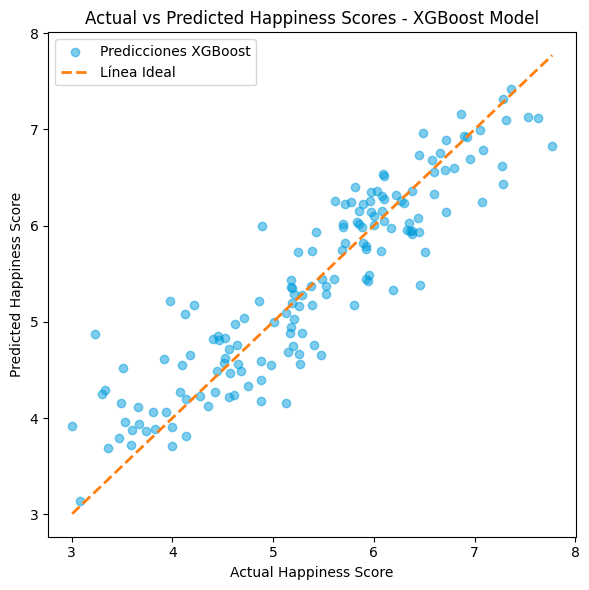

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya entrenaste todo como en tu bucle:
# models['XGBoost'] es tu pipeline con preprocessor + XGBRegressor

# 1. Generás las predicciones directamente del pipeline
xgb_preds = models['XGBoost'].predict(X_test)

# 2. Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, xgb_preds, alpha=0.5, color='#009DDC', label='Predicciones XGBoost')
plt.xlabel("Actual Happiness Score")
plt.ylabel("Predicted Happiness Score")
plt.title("Actual vs Predicted Happiness Scores - XGBoost Model")

# 3. Línea ideal 45°
min_val = min(y_test.min(), xgb_preds.min())
max_val = max(y_test.max(), xgb_preds.max())
plt.plot([min_val, max_val], [min_val, max_val],
         color=sns.color_palette()[1],
         linestyle='--', lw=2,
         label="Línea Ideal")

plt.legend()
plt.tight_layout()
plt.show()


In [15]:
os.makedirs("./data/model", exist_ok=True)
joblib.dump(models['XGBoost'], "./data/model/best_model_xgboost_pipeline.pkl")
print("✅ Pipeline XGBoost guardado en ./data/model/best_model_xgboost_pipeline.pkl")

✅ Pipeline XGBoost guardado en ./data/model/best_model_xgboost_pipeline.pkl
